In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10628279401468592507
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6714144194
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1817210028011783277
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [2]:
# plot image
from matplotlib import pyplot as plt
from matplotlib.image import imread
import numpy as np
# define location of dataset
folder = 'dogs-vs-cats/train/dog/'
plt.figure(figsize=(20,10))
# plot first few images
for i in range(9):
    # 3x3 subpot
    plt.subplot(3,3,1+i)
    # select one image from dataset at random
    filename = folder + 'dog.' + str(np.random.randint(1000)) + '.jpg'
    image = imread(filename)
    plt.imshow(image)
plt.show()

<Figure size 2000x1000 with 9 Axes>

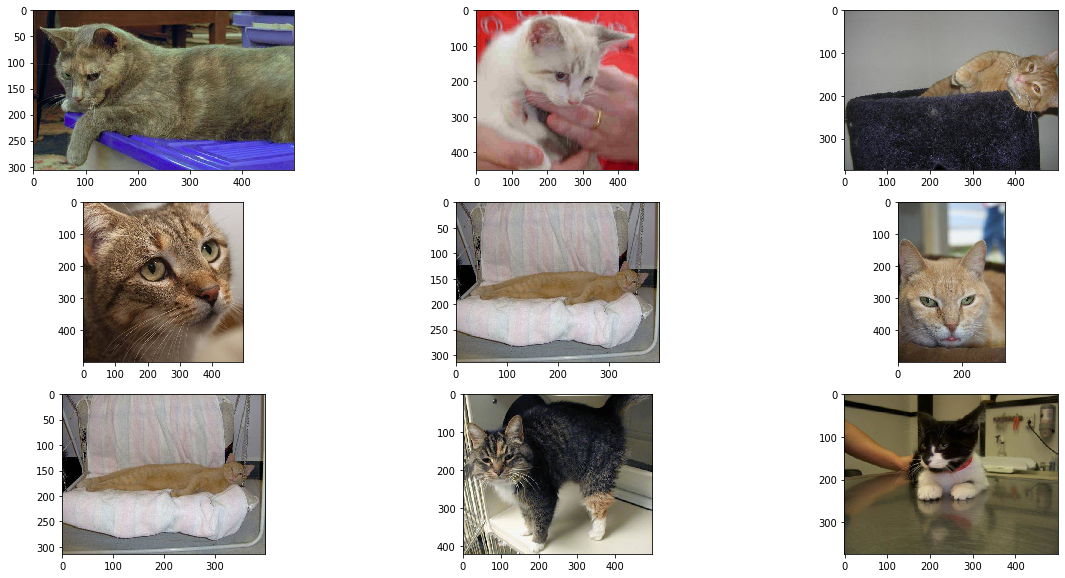

In [3]:
folder = 'dogs-vs-cats/train/cat/'
plt.figure(figsize=(20,10))
for i in range(9):
	plt.subplot(3, 3, 1+i)
	filename = folder + 'cat.' + str(np.random.randint(1000)) + '.jpg'
	image = imread(filename)
	plt.imshow(image)
plt.show()

In [4]:
from keras.preprocessing.image import ImageDataGenerator
resize = 220
train_dir = 'dogs-vs-cats/train/'
val_dir = 'dogs-vs-cats/validation/'
train_pic_gen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.5,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
val_pic_gen = ImageDataGenerator(rescale=1./255)
train_flow = train_pic_gen.flow_from_directory(train_dir,
                                               target_size=(resize,resize),
                                               batch_size=64,
                                               class_mode='binary')
val_flow = val_pic_gen.flow_from_directory(val_dir,
                                             target_size=(resize,resize),
                                             batch_size=64,
                                             class_mode='binary')
print(train_flow.class_indices)

Using TensorFlow backend.


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
{'cat': 0, 'dog': 1}


In [5]:
from keras.models import Sequential,Model
from keras.layers.normalization import BatchNormalization
from keras.layers import Dropout, Activation
from keras.layers import Dense,Input,Conv2D,MaxPooling2D,Flatten,ZeroPadding2D, Conv2D, AveragePooling2D
from keras import callbacks
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold,train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
from keras.utils import np_utils
from keras.optimizers import RMSprop

In [6]:
def lenet_5():
    
    model = Sequential()

    model.add(Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(resize,resize,3)))
    model.add(AveragePooling2D())

    model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
    model.add(AveragePooling2D())

    model.add(Flatten())

    model.add(Dense(units=120, activation='relu'))

    model.add(Dense(units=84, activation='relu'))

    model.add(Dense(units=1, activation = 'sigmoid'))

 
    return model


In [7]:
model = lenet_5()
model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 218, 218, 6)       168       
_________________________________________________________________
average_pooling2d_1 (Average (None, 109, 109, 6)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 107, 107, 16)      880       
_________________________________________________________________
average_pooling2d_2 (Average (None, 53, 53, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 44944)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               5393400   
_________________________________________________________________
dense_2 (Dense)              (None, 84)                10164     
__________

In [8]:
from datetime import datetime
logdir="logs/lenetfit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
CallBack = callbacks.TensorBoard(log_dir = logdir, 
                                 histogram_freq= 0,
                                 write_graph=True,
                                 write_images=True)

In [9]:
his = model.fit_generator(train_flow,
                    steps_per_epoch=100,
                    epochs=50,
                    verbose=1,
                    validation_data=val_flow,
                    validation_steps=50,
                    callbacks=[CallBack])

Epoch 1/50
100/100 [==============================] - 69s 691ms/step - loss: 0.6996 - binary_crossentropy: 0.6996 - val_loss: 0.6855 - val_binary_crossentropy: 0.6855
Epoch 2/50
100/100 [==============================] - 62s 623ms/step - loss: 0.6875 - binary_crossentropy: 0.6875 - val_loss: 0.6794 - val_binary_crossentropy: 0.6794
Epoch 3/50
100/100 [==============================] - 60s 604ms/step - loss: 0.6836 - binary_crossentropy: 0.6836 - val_loss: 0.6748 - val_binary_crossentropy: 0.6748
Epoch 4/50
100/100 [==============================] - 62s 622ms/step - loss: 0.6822 - binary_crossentropy: 0.6822 - val_loss: 0.6726 - val_binary_crossentropy: 0.6726
Epoch 5/50
100/100 [==============================] - 62s 618ms/step - loss: 0.6794 - binary_crossentropy: 0.6794 - val_loss: 0.6710 - val_binary_crossentropy: 0.6710
Epoch 6/50
100/100 [==============================] - 62s 622ms/step - loss: 0.6814 - binary_crossentropy: 0.6814 - val_loss: 0.6830 - val_binary_crossentropy: 0.683

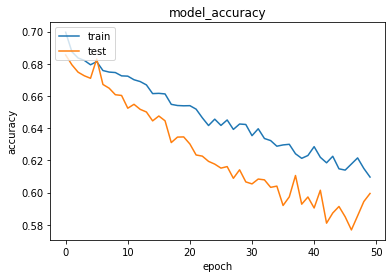

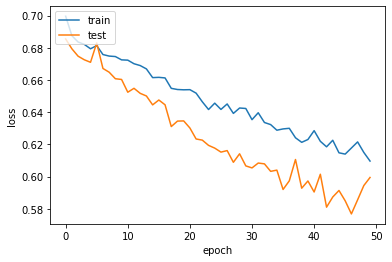

In [10]:
plt.plot(his.history['binary_crossentropy'])
plt.plot(his.history['val_binary_crossentropy'])
plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [11]:
model.save('./weights/lenet_catdogs_model.h5')

cat


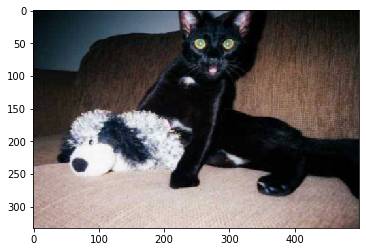

In [21]:
import cv2
model.load_weights('./weights/lenet_catdogs_model.h5')
folder = 'dogs-vs-cats/test/test1/'
filename = folder + str(np.random.randint(1000)) + '.jpg'
test_image = cv2.resize(cv2.imread(filename),(resize,resize))
test_image = np.asarray(test_image.astype("float32"))
test_image = test_image/255.
test_image = test_image.reshape((1,resize,resize,3))
preds = model.predict(test_image)
if preds <= 0.5:
    print("cat")
else:
    print("dog")
image = imread(filename)
plt.imshow(image)
#plt.show()